### An Empirical Study of Ensemble Techniques (Bagging, Boosting and Stacking)

This Notebook contains the code, process, mehods used when working on the research project titled above. Fist we present the abstract and then a link to the full paper.

### Abstract
Ensemble methods are popular strategies for improving the predictive ability of a
machine learning model. An ensemble consists of a set of individually trained base
learners/models whose predictions are combined when classifying new cases. Previous
researches have shown that an ensemble is on the average more accurate than a single
base model. Bagging, Boosting and Stacking are some popular ensemble techniques
which we studied in this paper. We evaluated these ensembles on 9 data sets. From our
results, we observed the following. First, an ensemble is always more accurate than a
single base model. Secondly, we observed that Boosting ensembles is on the average
better than Bagging while Stacking (meta-learning) is on the average more accurate than
Boosting and Bagging. Further experiment also shows that the gain in predictive power
of any ensembles may sometimes be small or even decrease depending on the data set.

#### Link to full paper [here]() 


In [1]:
#import some necessary librairies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


In [2]:
#Import datasets
loan_default = pd.read_csv('DSN_loan_default_ensemble_train.csv')
house_pricing = pd.read_csv('House_Prices_ensemble_research_train.csv')
tweets_data = pd.read_csv('retweet_prediction.csv')
traffic_data = pd.read_csv('Traffic_ticket_sales_ensemble_train.csv')
avocado_data = pd.read_csv('avocado.csv')
real_estate = pd.read_excel('Real estate valuation data set.xlsx')
german_cred = pd.read_csv('credit_preped.csv')
auto_mobile = pd.read_csv('auto_prices_preped.csv')
supermarket_sales = pd.read_csv('supermarket_sales.csv')

All data set have been cleaned and encoding from previous works. Below, in the nex cell, we perform a simple cleaning and transformation on the real estate, avocado and loan default data sets.

In [3]:
real_estate.drop(['No', 'X1 transaction date'],axis=1, inplace=True)
avocado_data.drop(['Unnamed: 0','Date'],axis=1, inplace=True)

#Encode data
avocado_data = pd.get_dummies(avocado_data)


#Fill missing values in loan dataset and supermarket sales data
from sklearn.impute import SimpleImputer

impute = SimpleImputer()
impute.fit(loan_default)
loan_default = impute.transform(loan_default)

impute = SimpleImputer()
impute.fit(supermarket_sales)
supermarket_sales = impute.transform(supermarket_sales)

Next, we seperate all targets from the data sets and assign them to new variables.

In [4]:

loan_default_target = loan_default['target']
loan_default.drop('target', axis=1, inplace=True)

house_pricing_target = house_pricing['target']
house_pricing.drop('target', axis=1, inplace=True)

tweets_data_target = tweets_data['retweets_target']
tweets_data.drop('retweets_target', axis=1, inplace=True)

traffic_data_target = traffic_data['target']
traffic_data.drop('target', axis=1, inplace=True)

avocado_data_target = avocado_data['AveragePrice']
avocado_data.drop('AveragePrice', axis=1, inplace=True)

real_estate_target = real_estate['Y house price of unit area']
real_estate.drop('Y house price of unit area', axis=1, inplace=True)

auto_mobile_target = auto_mobile['price']
auto_mobile.drop('price', axis=1, inplace=True)

german_cred_target = german_cred['age_yrs']
german_cred.drop('age_yrs', axis=1, inplace=True)

supermarket_sales_target = supermarket_sales['Product_Price']
supermarket_sales.drop('Product_Price', axis=1, inplace=True)

In [9]:
train_data = [loan_default, house_pricing,tweets_data,traffic_data,
              avocado_data, real_estate, auto_mobile, german_cred, supermarket_sales]

train_targets = [loan_default_target, house_pricing_target,tweets_data_target, traffic_data_target,
                 avocado_data_target, real_estate_target, auto_mobile_target, german_cred_target, supermarket_sales_target]

data_names = ['loan_default','house_pricing','tweets_data', 'traffic_data',
              'avocado_data', 'real_estate','auto_mobile', 'german_cred', 'supermarket_sales' ]



In [10]:
for i in range(len(data_names)):
    print('{}. shape of {} is {} and shape of target is {}'.format(i+1, data_names[i], train_data[i].shape, train_targets[i].shape))

1. shape of loan_default is (4368, 129) and shape of target is (4368,)
2. shape of house_pricing is (1458, 220) and shape of target is (1458,)
3. shape of tweets_data is (89309, 94) and shape of target is (89309,)
4. shape of traffic_data is (51645, 68) and shape of target is (51645,)
5. shape of avocado_data is (18249, 65) and shape of target is (18249,)
6. shape of real_estate is (414, 5) and shape of target is (414,)
7. shape of auto_mobile is (195, 66) and shape of target is (195,)
8. shape of german_cred is (1000, 62) and shape of target is (1000,)
9. shape of supermarket_sales is (4990, 32) and shape of target is (4990,)


## **MODELLING**

In [11]:
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
# from sklearn.metrics import mean_absolute_error
#import xgboost as xgb
from lightgbm import LGBMRegressor

r_seed = 200
np.random.seed(r_seed)



## Single Base models

In [11]:
#Single base models
lr = LinearRegression()
knn = KNeighborsRegressor()
rf = RandomForestRegressor(n_estimators=50)
et = ExtraTreesRegressor(n_estimators=50)

base_models = [lr,knn,rf,et]


#Boosting algorithms
gb = GradientBoostingRegressor(n_estimators=100)
ab = AdaBoostRegressor(n_estimators=100)
lgb_model = LGBMRegressor(n_estimators=100)

boost_model = [gb,ab,lgb_model]


## BASE MODEL AND BAGGING

In [13]:
for i, (x, y) in enumerate(zip(train_data, train_targets)):
    print("Data Set: {}".format(data_names[i]))
    #Loop through each model and cross validate
    for model in base_models:
        b_score = -1 * (cross_val_score(model, x, y, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error'))
        bagg_reg = BaggingRegressor(model, random_state=20)
        bagg_score = -1 * (cross_val_score(bagg_reg, x, y, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error'))
        
        print("MAE: {}, Model: {}".format(b_score[0], model.__class__.__name__))
        print("MAE: {}, Bagging Model: {}".format(bagg_score[0], model.__class__.__name__))
        print("----------------------------------------------")

    print('\n')

## BOOSTING

In [14]:
for i, (x, y) in enumerate(zip(train_data, train_targets)):
    print("Data Set: {}".format(data_names[i]))

    #Loop through each model and cross validate
    for model in boost_model:
        bst_score = -1 * (cross_val_score(model, x, y, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error'))        
#         bagg_reg = BaggingRegressor(model, random_state=20)
#         bagg_score = -1 * (cross_val_score(bagg_reg, x, y, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error'))
        
        print("MAE: {}, Model: {}".format(bst_score[0], model.__class__.__name__))
#         print("MAE: {}, Bagging Model: {}".format(bagg_score[0], model.__class__.__name__))

        print("----------------------------------------------")

    print('\n')


## Stacking  models

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.


**Stacking averaged Models Class**

In [15]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=10):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(np.array(X)[train_index], np.array(y)[train_index])
                y_pred = instance.predict(np.array(X)[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [17]:
first_learners = [knn, rf,et, gb,lgb_model]
stacked_averaged_models = StackingAveragedModels(base_models = first_learners,
                                                 meta_model = lgb_model)

In [ ]:
print("Using Stacking Model: Meta learner")
print("----------------------------------------------")

for i, (x, y) in enumerate(zip(train_data, train_targets)):
    print("Data Set: {}".format(data_names[i]))
    meta_score = -1 * (cross_val_score(stacked_averaged_models, x, y, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error'))        
    print("MAE: {} ".format(meta_score[0]))


### VISUALIZATION OF RESULTS

The result were hand recorded and saved to a csv file after observing the print outs from the training process.

In [2]:
#read csv of result
results = pd.read_csv('results_data.csv')

In [91]:
results

,Datasets,LR,KNN,RF,ET,LR_BAG,KNN_BAG,RF_BAG,ET_BAG,GB,ADAB,LGB,STACKED_MODEL
0,loan_default,0.321,0.324,0.328,0.328,0.319,0.314,0.311,0.320,0.303,0.355,0.293,0.300
1,house_pricing,2.457,0.164,0.097,0.089,0.082,0.161,0.094,0.084,0.080,0.102,0.079,0.079
2,tweets_data,6.503,5.706,6.133,6.124,6.400,5.787,6.118,6.102,5.822,20.937,5.768,5.611
3,traffic_data,15.500,4.833,4.367,4.393,15.130,4.350,4.320,4.251,4.104,4.147,4.059,4.027
4,avocado_data,0.145,0.227,0.128,0.137,0.145,0.225,0.122,0.130,0.123,0.210,0.115,0.132
5,real_estate,5.654,5.310,4.768,4.571,5.611,5.258,4.315,4.314,4.558,5.429,4.620,4.277
6,auto_mobile,4848.590,3649.450,2253.390,2199.360,4234.380,3641.140,2217.870,2101.130,2184.832,2209.549,2199.980,2101.070
7,german_cred,7.550,10.544,7.360,8.004,7.617,10.256,7.181,7.225,7.725,8.531,7.854,7.276
8,supermarket_sales,75.732,81.908,80.974,86.290,75.627,80.930,79.418,81.093,74.802,75.160,74.470,71.458


### VISUALIZATION OF RESULTS

In [4]:
avg_mae = results.sum(axis=0).drop(['Datasets'], axis=0)

single_vs_bag = avg_mae[0:8]
bag_vs_boost = avg_mae[4:11]
boost_vs_stacked = avg_mae[8:]

#### Single vs bagged ensembles (Avg MAE Plot)

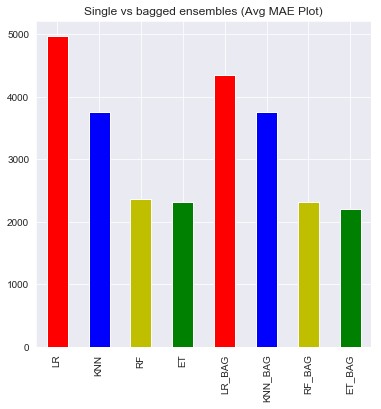

In [108]:
colors = ['r','b','y','g','r','b','y','g']

#Plot average comparison plots
fig = plt.figure(figsize=(6,6)) # define plot area
ax = fig.gca() # define axis  

single_vs_bag.plot.bar(ax=ax, color=colors)
ax.set_title('Single vs bagged ensembles (Avg MAE Plot)' )
plt.savefig('Single_vs_bagged_ensembles')

### Bagged vs Boost ensembles (Avg MAE Plot)

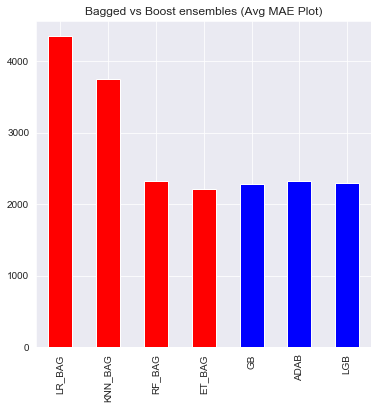

In [5]:
colors = ['r','r','r','r','b','b','b']

#Plot average comparison plots
fig = plt.figure(figsize=(6,6)) # define plot area
ax = fig.gca() # define axis  

bag_vs_boost.plot.bar(ax=ax, color=colors)
ax.set_title('Bagged vs Boost ensembles (Avg MAE Plot)' )
plt.savefig('Bagged_vs_Boost_ensembles')

### Boost vs stacked ensembles (Avg MAE Plot)

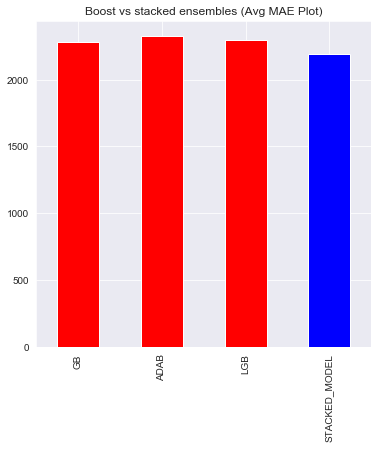

In [110]:
colors = ['r','r','r','b']

#Plot average comparison plots
fig = plt.figure(figsize=(6,6)) # define plot area
ax = fig.gca() # define axis  

boost_vs_stacked.plot.bar(ax=ax, color=colors)
ax.set_title('Boost vs stacked ensembles (Avg MAE Plot)' )
plt.savefig("Boost_vs_stacked_ensembles")

### Avg MAE Plot For all models

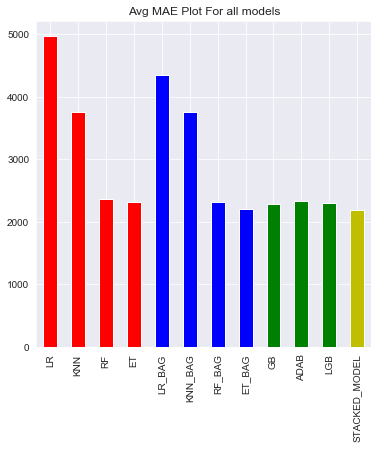

In [111]:
colors = ['r','r','r','r','b','b','b','b','g','g','g','y']

avg_mae = results.sum(axis=0).drop(['Datasets'], axis=0)
#Plot average plot

fig = plt.figure(figsize=(6,6)) # define plot area
ax = fig.gca() # define axis  

avg_mae.plot.bar(ax=ax, color=colors)
ax.set_title('Avg MAE Plot For all models' )
plt.savefig("Avg_MAE_Plot_For_all_models")

### MAE PLOT FOR ALL DATA SETS

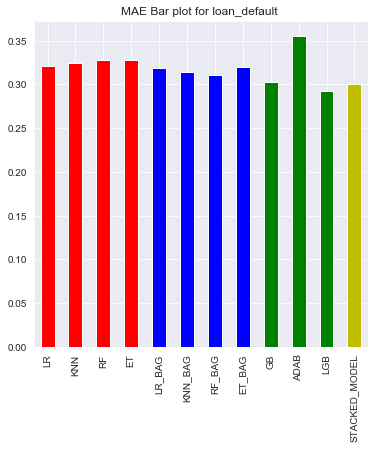

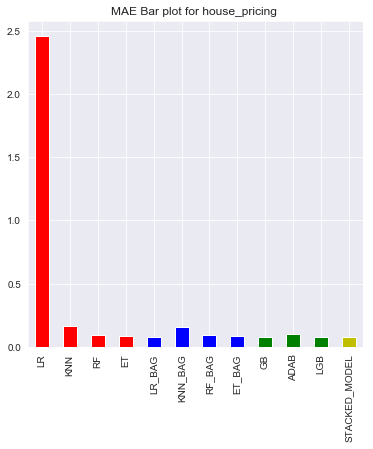

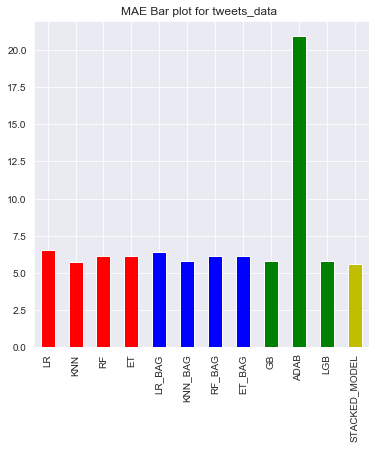

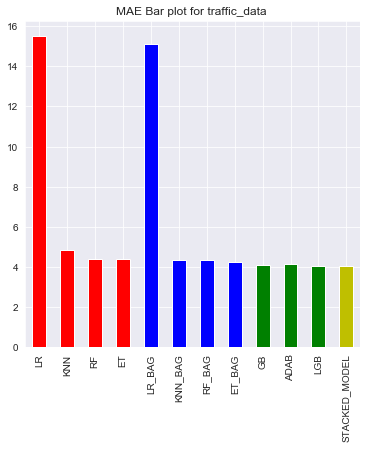

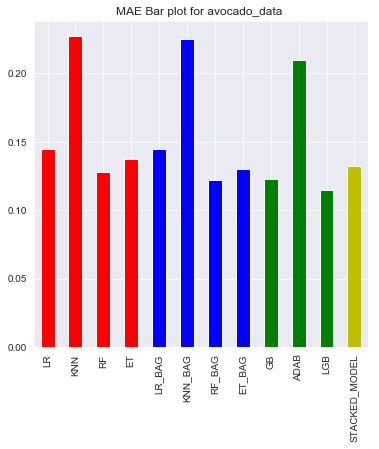

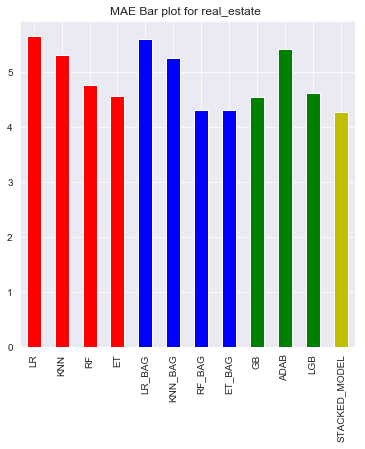

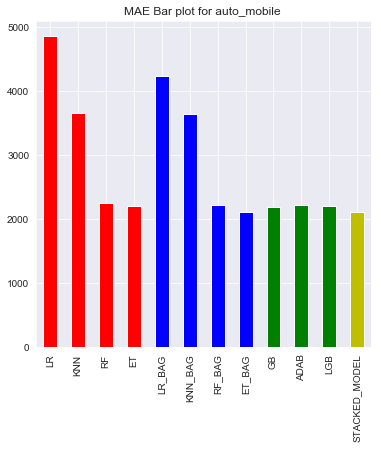

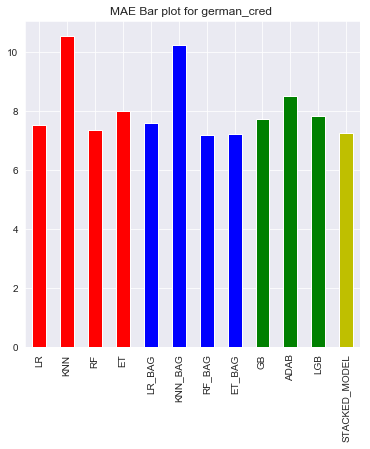

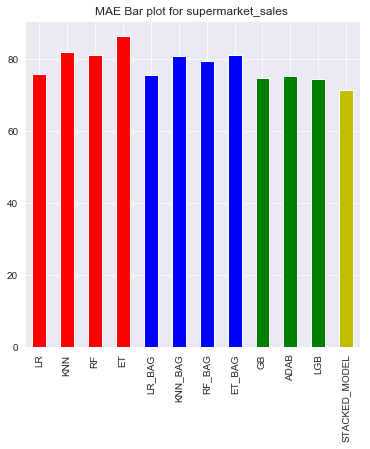

In [107]:
for i,dat_name in enumerate(results['Datasets']):
    fig = plt.figure(figsize=(6,6)) # define plot area
    ax = fig.gca() # define axis  
    
    results.iloc[i,1:].plot.bar(ax=ax, color=colors)
    ax.set_title('MAE Bar plot for ' + dat_name ) 
    